# Оптимизация марĸетинговых затрат в Яндеĸс.Афише

## Структура проекта:
* 1. [Предобработка данных](#preprocessing)       
* 2. [Построение отчётов и расчёт метрик](#calculating)
    * 2.1. [Продукт](#product)
    * 2.2. [Продажи](#sales)
    * 2.3. [Маркетинг](#marketing)    
* 3. [Общий вывод](#conclusion)

### Шаг 1. Предобработка данных
<a id="preprocessing"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits_log = pd.read_csv('data/visits_log.csv')
orders_log = pd.read_csv('data/orders_log.csv')
costs = pd.read_csv('data/costs.csv')

In [3]:
list_of_data = [visits_log, orders_log, costs]
visits_log.name = 'visits_log'
orders_log.name = 'orders_log'
costs.name = 'costs'
for data in list_of_data:
    print(data.name)
    display(data.head())
    print(data.info())
    print('*********************************')

visits_log


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
*********************************
orders_log


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
*********************************
costs


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None
*********************************


Видим, что в таблицах нет пропусков. Типы данных не соответсвуют в столбцах с датой, нужно поменять. Для удобства заменим названия в таблицах, приведем к нижнему регистру, избавимся от пробелов.

In [4]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [5]:
visits_log['End Ts'] = pd.to_datetime(visits_log['End Ts'], format='%Y-%m-%dT%H:%M:%S')
visits_log['Start Ts'] = pd.to_datetime(visits_log['Start Ts'], format='%Y-%m-%dT%H:%M:%S')
orders_log['Buy Ts'] = pd.to_datetime(orders_log['Buy Ts'], format='%Y-%m-%dT%H:%M:%S')

Приведем названия колонок к нижнему регистру и заменим пробел на нижнее подчеркивание

In [6]:
for data in list_of_data:
    data.columns = [column.lower().replace(' ', '_') for column in data.columns]

In [7]:
visits_log['start_ts'].min(), visits_log['start_ts'].max()

(Timestamp('2017-06-01 00:01:00'), Timestamp('2018-05-31 23:59:00'))

In [8]:
orders_log['buy_ts'].min(), orders_log['buy_ts'].max()

(Timestamp('2017-06-01 00:10:00'), Timestamp('2018-06-01 00:02:00'))

In [9]:
costs['dt'].min(), costs['dt'].max()

(Timestamp('2017-06-01 00:00:00'), Timestamp('2018-05-31 00:00:00'))

В orders_log последняя дата 1 июня 2018, в то время, как в остальных таблицах, данные не включают июнь и заканчиваются маем. Удалим данные за июня 2018 г

In [10]:
orders_log.query('buy_ts >= "2018-06-01"')

,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [11]:
orders_log.shape

(50415, 3)

In [12]:
orders_log = orders_log.query('buy_ts < "2018-06-01"')
orders_log.shape

(50414, 3)

Проверим данные на логику: есть ли в датафрейме visits_log строки, где время начала сессии превышает время окончания

In [13]:
visits_log[visits_log['start_ts'] > visits_log['end_ts']]

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Удалим эти 2 строчки из данных

In [14]:
visits_log = visits_log.query('start_ts <= end_ts')

In [15]:
visits_log.shape

(359398, 5)

Проверим, есть ли в датафрейме с покупками строки с нулевой выручкой или отрицательной, удалим строки при наличии. Также проверим нулевые и отрицательные расходы в costs

In [16]:
orders_log[orders_log['revenue'] <= 0].head()

,buy_ts,revenue,uid
1802,2017-06-22 18:19:00,0.0,17030528792926543083
2787,2017-07-07 15:54:00,0.0,10281425020415612933
4783,2017-08-02 14:54:00,0.0,184148767273119549
5095,2017-08-09 14:48:00,0.0,5603453646174104178
5863,2017-08-23 13:43:00,0.0,5603453646174104178


In [17]:
orders_log = orders_log.query('revenue > 0')

In [18]:
orders_log.shape

(50363, 3)

In [19]:
costs[costs['costs'] <= 0]

,source_id,dt,costs


#### Вывод

Форматы дат изменены на корректные. Названия в таблицах заменены на более удобные. Пропусков данных нет. Данные во всех таблицах представлены за одинаковый промежуток времени. Также данные проверены на логику, удалены строки, противоречащие здравому смыслу, где есть нулевая и отрицательная выручка и где время начала сессии больше, чем время ее окончания.

### Шаг 2. Построение отчётов и расчёт метрик
<a id="calculating"></a>

Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?


Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)


Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)
- Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

### 2.1 Продукт
<a id="product"></a>

**Посчитаем, сколько людей посещают сайт в день, неделю, месяц**

In [20]:
visits_log['date'] = pd.to_datetime(visits_log['start_ts'].dt.date)
visits_log['year_week'] = pd.to_datetime(visits_log['date'], unit='d') \
                        - pd.to_timedelta(visits_log['date'].dt.dayofweek, unit='d')
visits_log['year_month'] = visits_log['date'].astype('datetime64[M]')
visits_log['month'] = visits_log['start_ts'].dt.month
visits_log['year'] = visits_log['start_ts'].dt.year

In [21]:
users_daily = visits_log.groupby('date').agg({'uid' : 'nunique'}).reset_index()
users_weekly = visits_log.groupby('year_week').agg({'uid' : 'nunique'}).reset_index()
users_monthly = visits_log.groupby('year_month').agg({'uid' : 'nunique'}).reset_index()
users_monthly

,year_month,uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692
5,2017-11-01,32797
6,2017-12-01,31557
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473


In [22]:
dau = int(users_daily['uid'].mean())
wau = int(users_weekly['uid'].mean())
mau = int(users_monthly['uid'].mean())

In [23]:
mau

23228

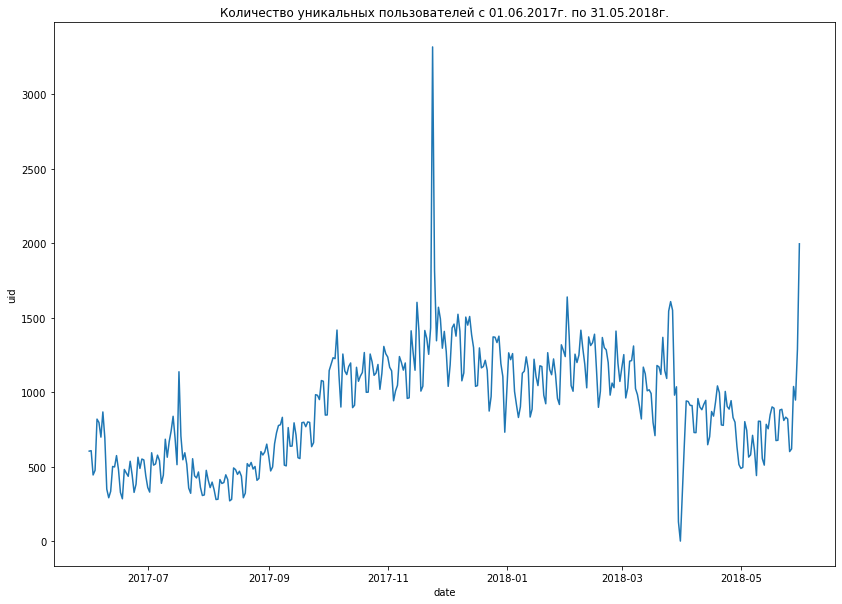

In [24]:
plt.figure(figsize=(14,10))
plt.title('Количество уникальных пользователей с 01.06.2017г. по 31.05.2018г.')
sns.lineplot(data=users_daily, x = 'date', y = 'uid');

В среднем сайт посещают 907 пользователей в день. Видим, что вначале нашей выборки это количество меньше - приблизительно 500 человек, затем видимо занялись активным привлечением клиентов и число пользователей растет до 1300-1500 человек, возможно это связано с тем, что продукт с октября по март пользуется большим спросом, что он сезонный. Далее число уникальных пользователей снижается. Есть 2 пика - примерно в новый год очень много пользователей пришло (что подтверждает предположение о сезонности), и в апреле число пользователей в краткосрочный период упало до нуля. Тут возможно были технические неполадки, следовало бы уточнить эту информацию у коллег, предоставивших данные.

In [25]:
wau

5716

In [26]:
visits_log.head()

,device,end_ts,source_id,start_ts,uid,date,year_week,year_month,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,12,2017


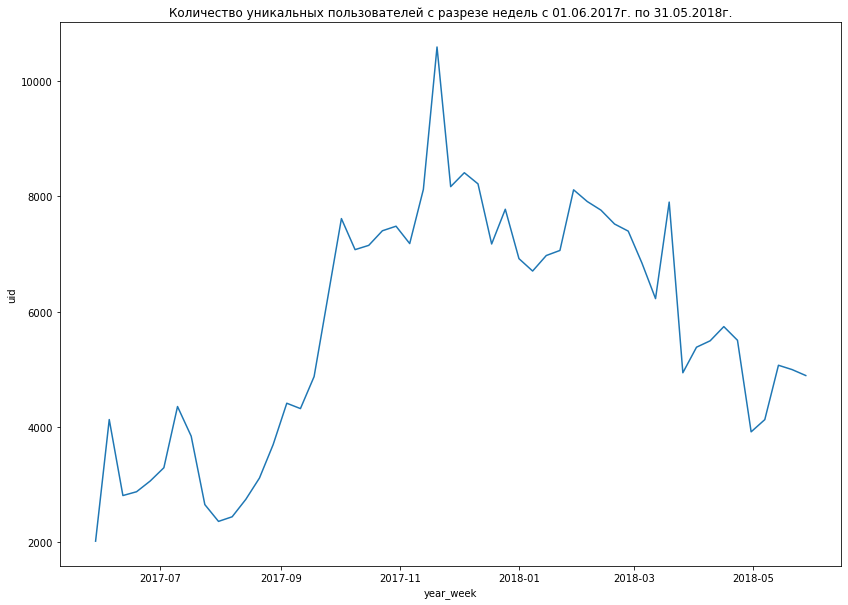

In [27]:
plt.figure(figsize=(14,10))
plt.title('Количество уникальных пользователей с разрезе недель с 01.06.2017г. по 31.05.2018г.')
sns.lineplot(data=users_weekly, x = 'year_week', y = 'uid');

В среднем - 5716 уникальных пользователй в неделю. График также показывает сначала низкий интерес пользователей, затем с осени по весну высокий, затем утихание. Посмотрим, что происходит в зависимости от дня недели.

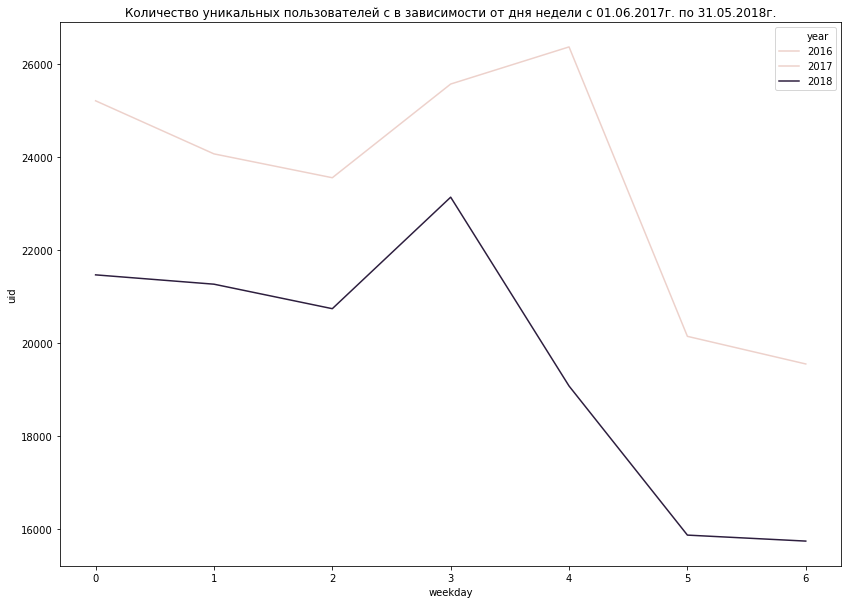

In [28]:
visits_log['weekday'] = visits_log['date'].dt.weekday
users_weekday = visits_log.groupby(['year', 'weekday']).agg({'uid' : 'nunique'}).reset_index()
plt.figure(figsize=(14,10))
plt.title('Количество уникальных пользователей с в зависимости от дня недели с 01.06.2017г. по 31.05.2018г.')
sns.lineplot(data=users_weekday, x = 'weekday', y = 'uid', hue = 'year');

Видим, что на выходных сайт непопулярен среди пользователей. Пик количества уникальных пользователей приходится на четверг-пятницу. В 2017 году в целом пользователей больше, чем в 2018

In [29]:
mau

23228

In [30]:
users_monthly

,year_month,uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692
5,2017-11-01,32797
6,2017-12-01,31557
7,2018-01-01,28716
8,2018-02-01,28749
9,2018-03-01,27473


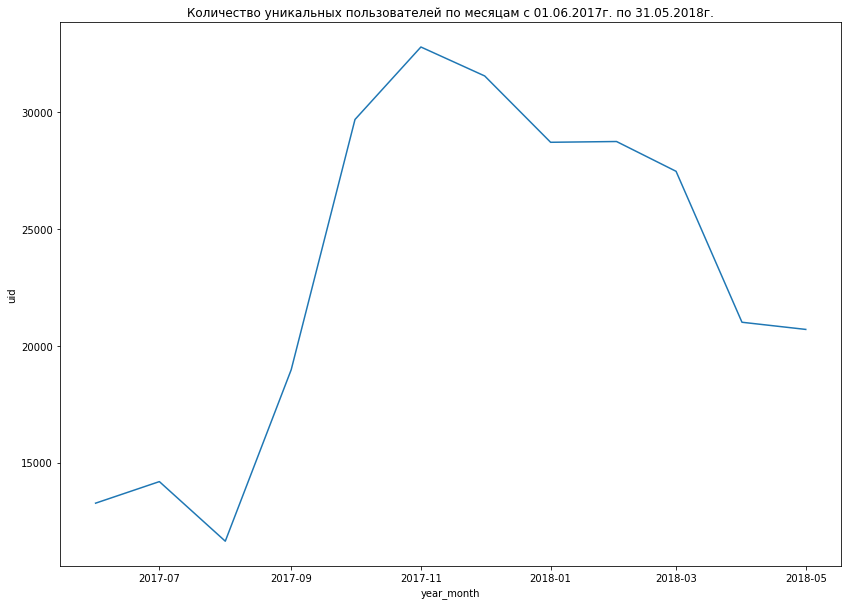

In [31]:
plt.figure(figsize=(14,10))
plt.title('Количество уникальных пользователей по месяцам с 01.06.2017г. по 31.05.2018г.')
sns.lineplot(data=users_monthly, x = 'year_month', y = 'uid');

В месяц посещают в среднем 23 тыс уникальных пользователей. Также видим возможную осенне-зимне-весеннюю сезонность или активную маркетинговую работу с октября по март. Но так как нам дан всего 1 год, не можем сделать точные выводы. Хорошо бы посмотреть данные еще за 1 год, чтобы делать предположения относительно этого.

Какова регулярность посещения сайтов? Примерно 4 раза в месяц, 16 раз в неделю

In [32]:
sticky_mau = dau / mau * 100
sticky_mau

3.9047701050456345

In [33]:
sticky_wau = dau / wau * 100
sticky_wau

15.867739678096571

Посмотрим, влияют ли девайсы и рекламные источники на данные показатели

In [34]:
visits_log['device'].value_counts()

desktop    262565
touch       96833
Name: device, dtype: int64

In [35]:
for device in visits_log['device'].unique():
    df_day = visits_log.query('device == @device') \
                       .groupby('date') \
                       .agg({'uid' : 'nunique'}) \
                       .reset_index()
    df_week = visits_log.query('device == @device') \
                       .groupby('year_week') \
                       .agg({'uid' : 'nunique'}) \
                       .reset_index()
    df_month = visits_log.query('device == @device') \
                       .groupby('year_month') \
                       .agg({'uid' : 'nunique'}) \
                       .reset_index()
    dau = int(df_day['uid'].mean())
    wau = int(df_week['uid'].mean())
    mau = int(df_month['uid'].mean())
    print('Устройство -', device)
    print('В среднем в день количество уникальных пользователей =', dau)
    print('В среднем в неделю количество уникальных пользователей =', wau)
    print('В среднем в месяц количество уникальных пользователей =', mau)

Устройство - touch
В среднем в день количество уникальных пользователей = 252
В среднем в неделю количество уникальных пользователей = 1634
В среднем в месяц количество уникальных пользователей = 6825
Устройство - desktop
В среднем в день количество уникальных пользователей = 659
В среднем в неделю количество уникальных пользователей = 4129
В среднем в месяц количество уникальных пользователей = 16724


In [36]:
visits_log['source_id'].value_counts()

4     101794
3      85609
5      66905
2      47626
1      34121
9      13276
10     10025
7         36
6          6
Name: source_id, dtype: int64

In [37]:
for source in visits_log['source_id'].unique():
    df_day = visits_log.query('source_id == @source') \
                       .groupby('date') \
                       .agg({'uid' : 'nunique'}) \
                       .reset_index()
    df_week = visits_log.query('source_id == @source') \
                       .groupby('year_week') \
                       .agg({'uid' : 'nunique'}) \
                       .reset_index()
    df_month = visits_log.query('source_id == @source') \
                       .groupby('year_month') \
                       .agg({'uid' : 'nunique'}) \
                       .reset_index()
    dau = int(df_day['uid'].mean())
    wau = int(df_week['uid'].mean())
    mau = int(df_month['uid'].mean())
    print('Рекламный источник -', source)
    print('В среднем в день количество уникальных пользователей =', dau)
    print('В среднем в неделю количество уникальных пользователей =', wau)
    print('В среднем в месяц количество уникальных пользователей =', mau)

Рекламный источник - 4
В среднем в день количество уникальных пользователей = 275
В среднем в неделю количество уникальных пользователей = 1829
В среднем в месяц количество уникальных пользователей = 7765
Рекламный источник - 2
В среднем в день количество уникальных пользователей = 120
В среднем в неделю количество уникальных пользователей = 715
В среднем в месяц количество уникальных пользователей = 2752
Рекламный источник - 5
В среднем в день количество уникальных пользователей = 175
В среднем в неделю количество уникальных пользователей = 1167
В среднем в месяц количество уникальных пользователей = 5017
Рекламный источник - 9
В среднем в день количество уникальных пользователей = 36
В среднем в неделю количество уникальных пользователей = 238
В среднем в месяц количество уникальных пользователей = 987
Рекламный источник - 3
В среднем в день количество уникальных пользователей = 232
В среднем в неделю количество уникальных пользователей = 1565
В среднем в месяц количество уникальных 

В среднем количество пользователей, использующих компьютер примерно в 3 раза больше, чем людей, использующих телефон/планшет. Здесь стоит выдвинуть гипотезу о статистически значимой разнице между ними.

Что касается рекламных источников:
В среднем количество пользователей, привлеченных из источников 4, 2, 3, 5 довольно высокое. Остальные источники имеют более малочисленное среднее количество пользователей.

# *******************************

**Сколько сессий в день?**

In [38]:
visits_per_user = visits_log.groupby(['date']).agg({'uid': ['count','nunique']})
visits_per_user.columns = ['n_visits', 'n_users']
visits_per_user['visits_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']
visits_per_user

,n_visits,n_users,visits_per_user
date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


In [39]:
visits_per_user['visits_per_user'].mean()

1.0821660876897365

Посмотрим, есть ли различия в устройствах и рекламных источниках:

In [40]:
for device in visits_log['device'].unique():
    visits_per_user = visits_log.query('device == @device').groupby(['date']).agg({'uid': ['count','nunique']})
    visits_per_user.columns = ['n_visits', 'n_users']
    visits_per_user['visits_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']
    visits_per_user['visits_per_user'].mean()
    print('Устройство =', device)
    print('Среднее количество сессий в день', round(visits_per_user['visits_per_user'].mean(), 2))

Устройство = touch
Среднее количество сессий в день 1.05
Устройство = desktop
Среднее количество сессий в день 1.09


In [42]:
for source in visits_log['source_id'].unique():
    visits_per_user = visits_log.query('source_id == @source').groupby(['date']).agg({'uid': ['count','nunique']})
    visits_per_user.columns = ['n_visits', 'n_users']
    visits_per_user['visits_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']
    print('Рекламный источник =', source)
    print('Среднее количество сессий в день', round(visits_per_user['visits_per_user'].mean(), 2))

Рекламный источник = 4
Среднее количество сессий в день 1.02
Рекламный источник = 2
Среднее количество сессий в день 1.08
Рекламный источник = 5
Среднее количество сессий в день 1.05
Рекламный источник = 9
Среднее количество сессий в день 1.01
Рекламный источник = 3
Среднее количество сессий в день 1.01
Рекламный источник = 1
Среднее количество сессий в день 1.15
Рекламный источник = 10
Среднее количество сессий в день 1.05
Рекламный источник = 7
Среднее количество сессий в день 1.0
Рекламный источник = 6
Среднее количество сессий в день 1.0


В среднем один пользователь заходит на сайт чуть больше одного раза в день. С компьютера немного чаще. Рекламные источники, предположительно повышающие число сессий в день - 1 и 2.

# *******************************

**Сколько длится одна сессия?**

In [41]:
new_visits_log = visits_log
new_visits_log['session_duration'] = (new_visits_log['end_ts'] - new_visits_log['start_ts']).dt.seconds

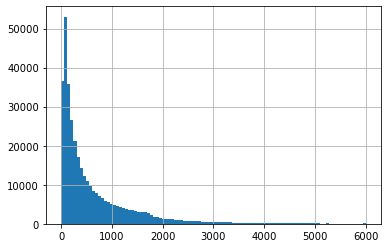

In [42]:
new_visits_log['session_duration'].hist(bins=100, range=(0, 6000));

In [43]:
asl = new_visits_log['session_duration'].mode()
asl

0    60
dtype: int64

Средняя продолжительность 1 сессии (asl) составляет 1 минуту.

Посмотрим также в разресе устройств и рекламных источников

In [44]:
for device in visits_log['device'].unique():
    new_visits_log = visits_log.query('device == @device')
    new_visits_log['session_duration'] = (new_visits_log['end_ts'] - new_visits_log['start_ts']).dt.seconds
    asl = new_visits_log['session_duration'].mode()
    print('Устройство - ', device)
    print('Средняя продолжительность сессии (сек) =', int(asl))

Устройство -  touch
Средняя продолжительность сессии (сек) = 60
Устройство -  desktop
Средняя продолжительность сессии (сек) = 60


In [45]:
for source in visits_log['source_id'].unique():
    new_visits_log = visits_log.query('source_id == @source')
    new_visits_log['session_duration'] = (new_visits_log['end_ts'] - new_visits_log['start_ts']).dt.seconds
    asl = new_visits_log['session_duration'].mode()
    print('Рекламный источник - ', source)
    try:
        print('Средняя продолжительность сессии (сек) =', int(asl))
    except TypeError:
        asl = asl.median()
        print('Средняя продолжительность сессии (сек) =', int(asl))

Рекламный источник -  4
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  2
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  5
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  9
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  3
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  1
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  10
Средняя продолжительность сессии (сек) = 60
Рекламный источник -  7
Средняя продолжительность сессии (сек) = 120
Рекламный источник -  6
Средняя продолжительность сессии (сек) = 420


In [46]:
visits_log.query('source_id == 7').shape[0], visits_log.query('source_id == 6').shape[0]

(36, 6)

Видим, что средняя продолжительность сессии составляет 60 сек, устройства на это не влияют. Рекламные источники 7 и 6 имеют иную среднюю продолжительность. Но сессий из таких источников мало, чтобы выявить закономерность. 7 источник более многочисленный, возможно, действиетльно, пользователи, пришедшие оттуда используют сайт более длительное время в среднем.

# *******************************

**Как часто люди возвращаются?**

Для ответа на этот вопрос расчитаем показатель Retention Rate. Для это необходимо провести когортный анализ. Выделим дату, когда пользователи впервые зашли на сайт, построим когорты с периодом в 1 месяц. Для каждой строки датафрейма рассчитаем lifetime пользователя в рамках когорты. Посчитаем для каждой когорты количество активных пользователей на каждый месяц.

In [47]:
first_visit_date = visits_log.groupby('uid')['date'].min()
first_visit_date.name = 'first_visit_date'
first_visit_date

uid
11863502262781         2018-03-01
49537067089222         2018-02-06
297729379853735        2017-06-07
313578113262317        2017-09-18
325320750514679        2017-09-30
                          ...    
18446403737806311543   2017-11-30
18446424184725333426   2017-12-06
18446556406699109058   2018-01-01
18446621818809592527   2017-12-27
18446676030785672386   2017-10-04
Name: first_visit_date, Length: 228169, dtype: datetime64[ns]

In [48]:
visits_log = visits_log.join(first_visit_date, on='uid')
visits_log['first_visits_month'] = visits_log['first_visit_date'].astype('datetime64[M]')
visits_log['cohort_lifetime'] = ((visits_log['start_ts'] - visits_log['first_visits_month']) / np.timedelta64(1, 'M')).astype('int')

In [49]:
user_chohorts = visits_log.groupby(['first_visits_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

Найдем Retention Rate, сперва получим число пользователей, изначально бывших в когорте(cohort_lifetime = 0), и на него разделим число пользователей в каждый следующий месяц.

In [50]:
initial_users_count = user_chohorts[user_chohorts['cohort_lifetime'] == 0][['first_visits_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_uid'})
initial_users_count

,first_visits_month,cohort_uid
0,2017-06-01,13259
12,2017-07-01,12856
24,2017-08-01,9749
34,2017-09-01,16704
43,2017-10-01,25256
51,2017-11-01,27248
58,2017-12-01,24882
64,2018-01-01,21945
69,2018-02-01,22197
73,2018-03-01,20588


In [51]:
user_chohorts = user_chohorts.merge(initial_users_count, on='first_visits_month')
user_chohorts

,first_visits_month,cohort_lifetime,uid,cohort_uid
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1030,13259
2,2017-06-01,2,687,13259
3,2017-06-01,3,834,13259
4,2017-06-01,4,899,13259
...,...,...,...,...
77,2018-04-01,0,15709,15709
78,2018-04-01,1,751,15709
79,2018-04-01,2,4,15709
80,2018-05-01,0,14207,14207


In [52]:
user_chohorts['retention'] = user_chohorts['uid'] / user_chohorts['cohort_uid']

In [53]:
retention_pivot = user_chohorts.pivot_table(index='first_visits_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,,
2017-06-01,1.0,0.077683,0.051814,0.062901,0.067803,0.072404,0.061769,0.055887,0.055585,0.049778,0.041255,0.044347
2017-07-01,1.0,0.077551,0.053438,0.056394,0.060750,0.049860,0.045348,0.050249,0.039281,0.029325,0.027769,0.000544
2017-08-01,1.0,0.121859,0.063186,0.066879,0.052210,0.045133,0.041132,0.039491,0.029644,0.026567,NaN,NaN
2017-09-01,1.0,0.084471,0.069504,0.050347,0.038733,0.040769,0.033645,0.024784,0.022150,NaN,NaN,NaN
2017-10-01,1.0,0.109202,0.053690,0.039040,0.038644,0.031834,0.022173,0.020787,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.077400,0.043343,0.041838,0.031745,0.024222,0.021066,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.070975,0.041315,0.030584,0.020979,0.018929,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.094919,0.037548,0.026156,0.020369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.050457,0.025769,0.019462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту

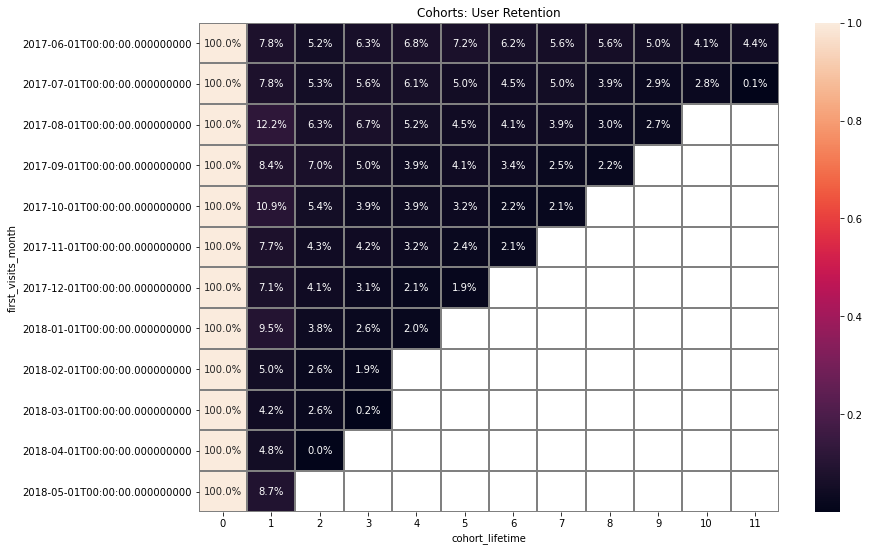

In [54]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

Видно, что большинство пользователей в когорте активны только в первый месяц, далее их число снижается резко. Удалим первый месяц расчетов из тепловой катры, чтобы было лучше, что происходит после первого месяца в когортах

In [55]:
retention_pivot_closer = user_chohorts.query('cohort_lifetime > 0').pivot_table(index='first_visits_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
retention_pivot_closer

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_visits_month,,,,,,,,,,,
2017-06-01,0.077683,0.051814,0.062901,0.067803,0.072404,0.061769,0.055887,0.055585,0.049778,0.041255,0.044347
2017-07-01,0.077551,0.053438,0.056394,0.060750,0.049860,0.045348,0.050249,0.039281,0.029325,0.027769,0.000544
2017-08-01,0.121859,0.063186,0.066879,0.052210,0.045133,0.041132,0.039491,0.029644,0.026567,NaN,NaN
2017-09-01,0.084471,0.069504,0.050347,0.038733,0.040769,0.033645,0.024784,0.022150,NaN,NaN,NaN
2017-10-01,0.109202,0.053690,0.039040,0.038644,0.031834,0.022173,0.020787,NaN,NaN,NaN,NaN
2017-11-01,0.077400,0.043343,0.041838,0.031745,0.024222,0.021066,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.070975,0.041315,0.030584,0.020979,0.018929,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.094919,0.037548,0.026156,0.020369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.050457,0.025769,0.019462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


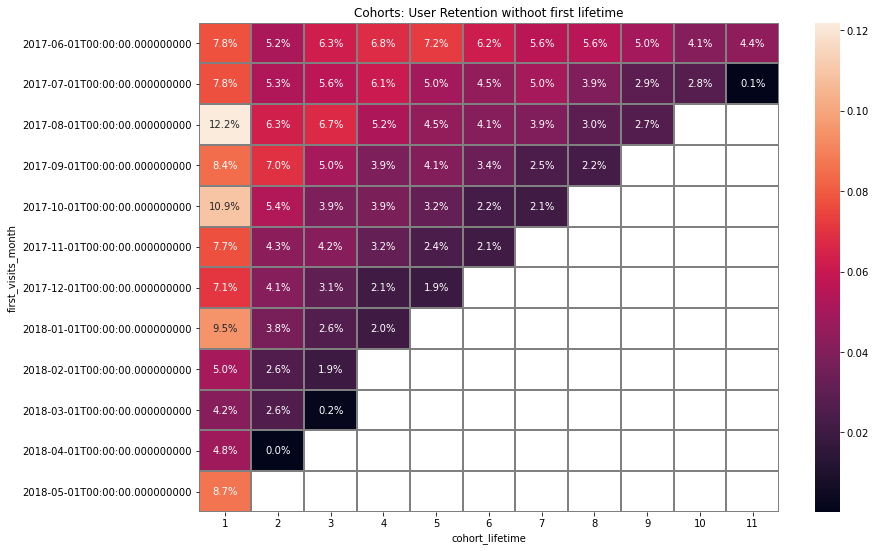

In [56]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention withoot first lifetime')
sns.heatmap(retention_pivot_closer, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

За редким исключением (например, в верхней когорте пользователей, пришедших в июне 2017 года, где есть месяцы с ростом визотов на сайт), численность когорт падает из месяца в месяц. Причем ориентировочно 90 % всех пользователей заходят на сайт только в первый месяц своего появления и уходят. Процент пользователей после 1 месяца жизни падает для более свежи когорт

### 2.2 Продажи
<a id="salest"></a>

**Когда люди начинают покупать?**

Чтобы ответить на этот вопрос нужен датафрейм, содержащий время первого визита пользователя, время первой покупки. Добавим данную информацию в таблицы с визитами и заказами соответсвенно

In [57]:
first_buy_ts = orders_log.groupby('uid')['buy_ts'].min()
first_buy_ts.name = 'first_buy_ts'
orders_log = orders_log.join(first_buy_ts,on='uid')
orders_log

,buy_ts,revenue,uid,first_buy_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00
...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2018-05-31 23:43:00
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00


In [58]:
first_visit_ts = visits_log.groupby('uid')['start_ts'].min()
first_visit_ts.name = 'first_visit_ts'
visits_log = visits_log.join(first_visit_ts,on='uid')
visits_log

,device,end_ts,source_id,start_ts,uid,date,year_week,year_month,month,year,weekday,session_duration,first_visit_date,first_visits_month,cohort_lifetime,first_visit_ts
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-18,2017-12-01,12,2017,2,1080,2017-12-20,2017-12-01,0,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-19,2018-02-01,2,2018,0,1680,2018-02-19,2018-02-01,0,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-26,2017-07-01,7,2017,5,0,2017-07-01,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,5,2018,6,1440,2018-03-09,2018-03-01,2,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-25,2017-12-01,12,2017,2,0,2017-12-27,2017-12-01,0,2017-12-27 14:06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,2017-07-24,2017-07-01,7,2017,5,19,2017-07-29,2017-07-01,0,2017-07-29 19:07:00
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,2018-01-22,2018-01-01,1,2018,3,19,2018-01-25,2018-01-01,0,2018-01-25 17:38:00
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,2018-02-26,2018-03-01,3,2018,5,19,2018-03-03,2018-03-01,0,2018-03-03 10:12:00
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,2017-10-30,2017-11-01,11,2017,3,19,2017-11-02,2017-11-01,0,2017-11-02 10:12:00


Соединим визиты и заказы в одну таблицу по пользователю

In [59]:
buying_merge = visits_log.merge(orders_log, on='uid')
buying_merge

,device,end_ts,source_id,start_ts,uid,date,year_week,year_month,month,year,weekday,session_duration,first_visit_date,first_visits_month,cohort_lifetime,first_visit_ts,buy_ts,revenue,first_buy_ts
0,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-14,2018-05-01,5,2018,6,1440,2018-03-09,2018-03-01,2,2018-03-09 20:05:00,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
1,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-05,2018-03-01,3,2018,4,1680,2018-03-09,2018-03-01,0,2018-03-09 20:05:00,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
2,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-28,2017-09-01,9,2017,6,60,2017-09-03,2017-09-01,0,2017-09-03 21:35:00,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00
3,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-28,2017-09-01,9,2017,6,60,2017-09-03,2017-09-01,0,2017-09-03 21:35:00,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,2017-08-28,2017-09-01,9,2017,6,60,2017-09-03,2017-09-01,0,2017-09-03 21:35:00,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759777,desktop,2017-12-04 12:50:00,3,2017-12-04 12:42:00,6752020629696526518,2017-12-04,2017-12-04,2017-12-01,12,2017,0,480,2017-12-04,2017-12-01,0,2017-12-04 12:42:00,2017-12-04 12:46:00,4.15,2017-12-04 12:46:00
759778,desktop,2017-11-20 23:44:00,4,2017-11-20 23:33:00,11750532881998794555,2017-11-20,2017-11-20,2017-11-01,11,2017,0,660,2017-11-20,2017-11-01,0,2017-11-20 23:33:00,2017-11-20 23:43:00,3.67,2017-11-20 23:43:00
759779,touch,2017-11-29 20:48:00,4,2017-11-29 20:27:00,11202626539189016002,2017-11-29,2017-11-27,2017-11-01,11,2017,2,1260,2017-11-29,2017-11-01,0,2017-11-29 20:27:00,2017-11-29 20:33:00,3.05,2017-11-29 20:33:00
759780,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23,2018-04-23,2018-04-01,4,2018,0,480,2018-04-23,2018-04-01,0,2018-04-23 21:11:00,2018-04-23 21:16:00,0.49,2018-04-23 21:16:00


Посчитаем время между первой покупкой и первым визитом, посмотрим на гистограмму, как это время распределено

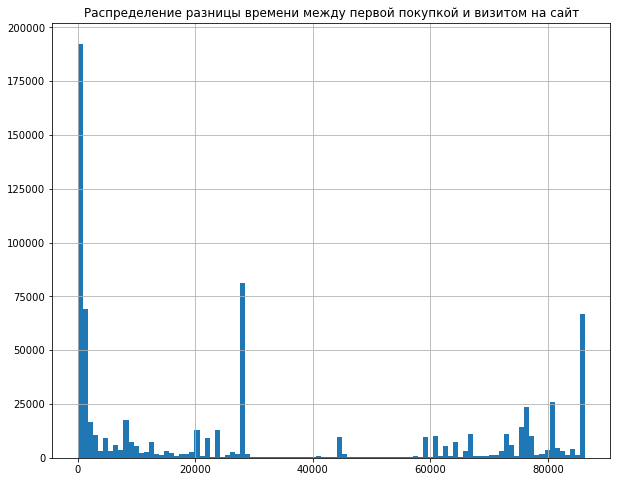

In [60]:
buying_merge['buy_visit_duration'] = (buying_merge['first_buy_ts'] - \
                                      buying_merge['first_visit_ts']).dt.seconds
plt.figure(figsize=(10,8))
buying_merge['buy_visit_duration'].hist(bins=100);
plt.title('Распределение разницы времени между первой покупкой и визитом на сайт')
plt.show()

Видим, что распределение не нормальное и среднее значение нам не даст правильную информацию. При этом у нас есть много значений, где длительность нулевая. Здесь видимо технически есть неточности работы, следовало бы поспрашивать про эти данные и выяснить, как это произошло. Сейчас же исключим эти строки из расчета, так как хотебя полминуты нужно покидать товары в корзину и тд, мгновенно покупку не совершить. Так

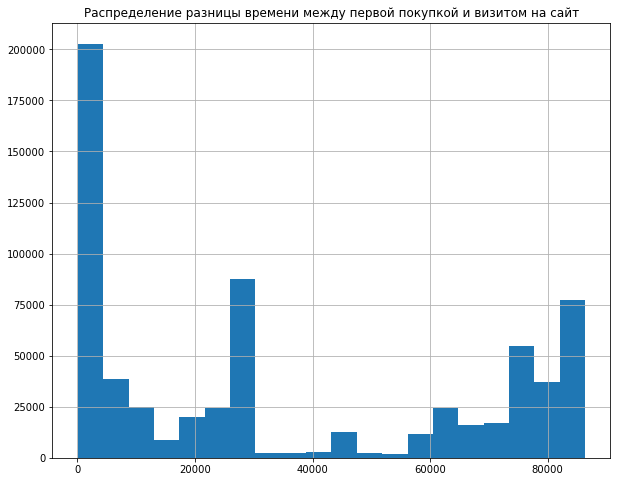

In [61]:
plt.figure(figsize=(10,8))
buying_merge[(buying_merge['buy_visit_duration'] > 0)]['buy_visit_duration'].hist(bins=20);
plt.title('Распределение разницы времени между первой покупкой и визитом на сайт')
plt.show()

Большинство значений выстроились у нуля. При этом есть много пользователей, покупающих товар позднее 5ти часов с начала первого визита. Но сконцентрируемся именно на самом частом значении, находящемся около 0

In [62]:
buying_merge[(buying_merge['buy_visit_duration'] > 0) & \
             (buying_merge['buy_visit_duration'] < 10000)] \
            ['buy_visit_duration'].mode() / 60

0    17.0
dtype: float64

Итак, чаще всего первую покупку делают через 17 минут со времени первого визита на сайт. Кажется реальным.

# *******************************

**Сколько раз покупают за период?**

Чтобы ответить на этот вопрос, нужно в датафрейме с покупками выделить столбцы с годом, месяцем, неделей, датой. Посмотрим, сколько покупают в месяц. Для этого сделаем табличку с количеством уникальных пользователей и в целом сколько было транзакций. Поделим транзакции на уникальных пользователей

In [63]:
orders_log['year'] = orders_log['buy_ts'].dt.year
orders_log['month'] = orders_log['buy_ts'].dt.month
orders_log['week'] = orders_log['buy_ts'].dt.week
orders_log['year_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_log['day'] = orders_log['buy_ts'].dt.day

In [64]:
buying_per_user = orders_log.groupby('year_month').agg({'uid': ['count','nunique']})
buying_per_user.columns = ['n_sessions', 'n_users']
buying_per_user['buying_per_user'] = buying_per_user['n_sessions'] / buying_per_user['n_users']
buying_per_user = buying_per_user.reset_index()
buying_per_user

,year_month,n_sessions,n_users,buying_per_user
0,2017-06-01,2353,2022,1.163699
1,2017-07-01,2362,1983,1.191125
2,2017-08-01,1803,1471,1.225697
3,2017-09-01,3383,2748,1.231077
4,2017-10-01,5677,4673,1.214851
5,2017-11-01,5644,4543,1.242351
6,2017-12-01,6206,4937,1.257039
7,2018-01-01,4721,3898,1.211134
8,2018-02-01,5280,4258,1.240019
9,2018-03-01,5325,4181,1.273619


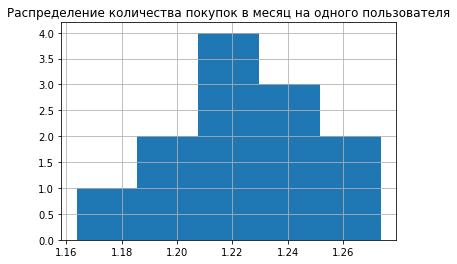

1.226061276529754

In [65]:
buying_per_user['buying_per_user'].hist(bins=5);
plt.title('Распределение количества покупок в месяц на одного пользователя')
plt.show()
buying_per_user['buying_per_user'].median()

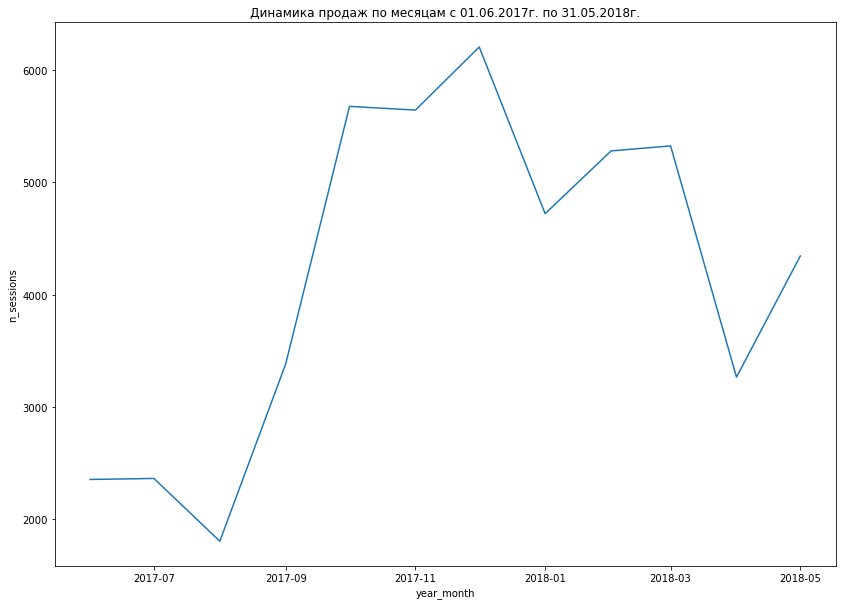

In [66]:
plt.figure(figsize=(14,10))
plt.title('Динамика продаж по месяцам с 01.06.2017г. по 31.05.2018г.')
sns.lineplot(data=buying_per_user, x = 'year_month', y = 'n_sessions');

В среднем, 1 пользователь покупает чуть больше одного раза в месяц. По динамике продаж видим всё ту же картину, основные продажи приходятся на октябрь-март.

# *******************************

**Какой средний чек?**


Выделим в таблице с заказами столбцы в месяцем покупки и месяцем первой покупки, чтобы сгруппировать по ним пользователей и сумму покупок, поделим сумму на пользователей, чтобы узнать какая средняя сумма транзакций

In [67]:
orders_log.head()

,buy_ts,revenue,uid,first_buy_ts,year,month,week,year_month,day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017,6,22,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017,6,22,2017-06-01,1
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017,6,22,2017-06-01,1
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017,6,22,2017-06-01,1
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017,6,22,2017-06-01,1


In [68]:
orders_log['first_buy_month'] = orders_log['first_buy_ts'].astype('datetime64[M]')
orders_log['buy_month'] = orders_log['buy_ts'].astype('datetime64[M]')

In [69]:
buying_grouped_cohort = orders_log.groupby(['first_buy_month', 'buy_month']) \
                                .agg({'uid':'count','revenue':'sum'})
buying_grouped_cohort

uid   revenue
first_buy_month buy_month                 
2017-06-01      2017-06-01  2353   9557.49
                2017-07-01   177    981.82
                2017-08-01   171    885.34
                2017-09-01   224   1931.30
                2017-10-01   291   2068.58
...                          ...       ...
2018-03-01      2018-04-01   178   1063.05
                2018-05-01   176   1114.87
2018-04-01      2018-04-01  2487  10600.69
                2018-05-01   195   1209.92
2018-05-01      2018-05-01  3247  13925.76

[78 rows x 2 columns]

In [70]:
buying_grouped_cohort['revenue_per_user'] = buying_grouped_cohort['revenue'] / buying_grouped_cohort['uid']
buying_grouped_cohort = buying_grouped_cohort.reset_index()
buying_grouped_cohort_pivot = buying_grouped_cohort.pivot_table(index='first_buy_month',columns='buy_month',values='revenue_per_user',aggfunc='mean')
buying_grouped_cohort_pivot

buy_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_buy_month,,,,,,,,,,,,
2017-06-01,4.061832,5.547006,5.177427,8.621875,7.108522,6.825321,6.986545,6.761839,5.279009,8.009869,12.038125,6.042093
2017-07-01,NaN,5.289542,6.446100,9.992083,6.637596,4.721806,3.659512,3.789508,5.454400,5.345690,11.790000,5.648302
2017-08-01,NaN,NaN,4.718557,5.987315,6.281200,6.617901,7.962941,6.265323,5.890000,7.113590,8.702826,5.598478
2017-09-01,NaN,NaN,NaN,4.970498,13.231606,8.380750,62.570244,15.430448,15.321835,16.923832,11.206607,7.785574
2017-10-01,NaN,NaN,NaN,NaN,4.374738,7.405127,5.127469,5.590246,5.098992,5.071553,4.280233,4.009120
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.384218,4.170103,4.474670,6.284976,4.467778,3.726780,4.598235
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.114869,4.226741,20.072772,26.084358,15.948488,14.111048
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.687417,4.438482,6.454969,7.524844,2.711282
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.707171,4.576486,3.453735,3.867143


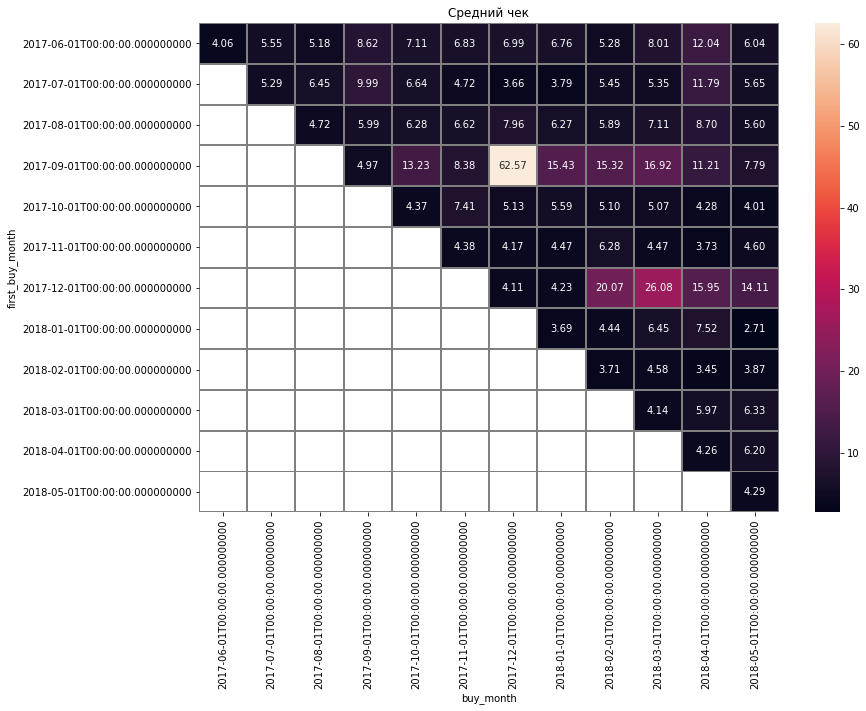

In [71]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
sns.heatmap(buying_grouped_cohort_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 

Средний чек с течением времени меняется. В первые месяцы он сотавляет 4-5 у.е, в некоторых когортах есть всплески активности покупок. Но эти всплески приходятся опять же на октябрь-март и только в единичных когортах. Когорта от декабря 2017 г показывает хороший средний чек вплодь до конча нащей выборки. Хорошо бы понять, чем она отличается от других когорт. Возможно особенные условия были предложены за повторные покупки. В реальной жизни, можно было бы задать вопросы относительно этой когорты и когорты от сенября 2017г.

# *******************************

**Сколько денег приносят? (LTV)**

Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. Нам нужен LTV по источникам, сгруппируем по ним и посчитаем средний наколенный LTV по каждому источнику в соответсвии с lifetime

In [72]:
# добавим данные о ресурсах в таблицу с заказами
users_source = visits_log.sort_values(by='start_ts').groupby('uid')['source_id'].first()
orders_log= pd.merge(orders_log, users_source, on='uid')

In [73]:
# формируем когорты со срезом по source_id
cohorts = orders_log.groupby(['first_buy_month', 'buy_month', 'source_id']).agg({'revenue': 'sum'}).reset_index()

In [74]:
# считаем количество пользователей в каждой когорте
cohort_sizes = orders_log.groupby(['first_buy_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'source_id', 'n_buyers']
cohort_sizes

,first_buy_month,source_id,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,234
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
80,2018-05-01,3,844
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60


In [75]:
cohorts = pd.merge(cohort_sizes, cohorts, on=['first_buy_month', 'source_id'])
cohorts

,first_buy_month,source_id,n_buyers,buy_month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20
...,...,...,...,...,...
510,2018-05-01,3,844,2018-05-01,3256.54
511,2018-05-01,4,804,2018-05-01,3802.91
512,2018-05-01,5,497,2018-05-01,2094.04
513,2018-05-01,9,60,2018-05-01,223.05


In [76]:
cohorts['cohort_lifetime'] = ((cohorts['buy_month'] - cohorts['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')
cohorts

,first_buy_month,source_id,n_buyers,buy_month,revenue,cohort_lifetime
0,2017-06-01,1,190,2017-06-01,1378.70,0
1,2017-06-01,1,190,2017-07-01,414.98,1
2,2017-06-01,1,190,2017-08-01,419.43,2
3,2017-06-01,1,190,2017-09-01,714.24,3
4,2017-06-01,1,190,2017-10-01,811.20,4
...,...,...,...,...,...,...
510,2018-05-01,3,844,2018-05-01,3256.54,0
511,2018-05-01,4,804,2018-05-01,3802.91,0
512,2018-05-01,5,497,2018-05-01,2094.04,0
513,2018-05-01,9,60,2018-05-01,223.05,0


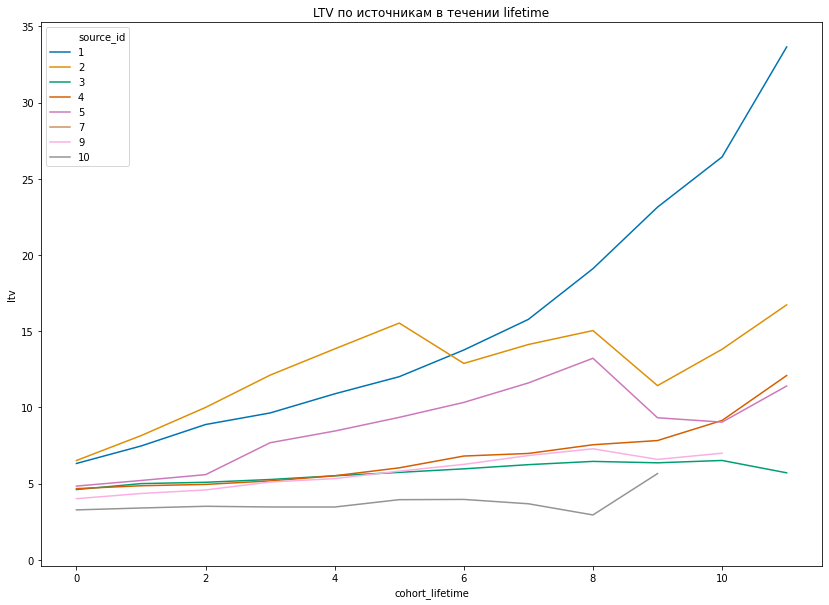

In [77]:
# рассчитаем LTV как отношение валовой прибыли за месяц к размеру соответствующей когорты
margin_rate = 1
cohorts['ltv'] = cohorts['revenue'] * margin_rate / cohorts['n_buyers']
 
 
# создаем новую агрегирующую таблицу
cumsum_by_grouper = pd.DataFrame(columns=['cohort_lifetime', 'source_id', 'ltv'])
 
# цикл повторяется по всем значениям группирующей переменной
for grouper_value in cohorts['source_id'].unique():
 
    # по умолчанию сводная таблица высчитывает среднее значение заданного показателя; 
    # предполагается к получению таблица с когортами, где первым столбцом будет дата образования когорты
    pivot = cohorts[cohorts['source_id'] == grouper_value].pivot_table(index=cohorts[cohorts.columns[0]], columns='cohort_lifetime', values='ltv')
 
    # считаем накопленную сумму на каждое значение времени жизни когорты и усредняем
    result = pivot.cumsum(axis=1).mean(axis=0).rename('ltv').reset_index()
    result['source_id'] = grouper_value
 
    # включаем в таблицу среднюю накопленную сумму
    cumsum_by_grouper = cumsum_by_grouper.append(result, sort=False)
 
# приводим к правильным типам данных
cumsum_by_grouper['cohort_lifetime'] = cumsum_by_grouper['cohort_lifetime'].astype(int)
cumsum_by_grouper['source_id'] = cumsum_by_grouper['source_id'].astype(int)
 
# рисуем график
plt.figure(figsize=(14,10))
plt.title('LTV по источникам в течении lifetime')
palette_ltv = sns.color_palette("colorblind", cumsum_by_grouper['source_id'].nunique())
sns.lineplot(data=cumsum_by_grouper, x='cohort_lifetime', y='ltv', hue='source_id', legend='full', palette=palette_ltv);

In [78]:
ltv_pivot = cumsum_by_grouper.pivot(index='cohort_lifetime', columns='source_id', values='ltv')
ltv_pivot

source_id,1,2,3,4,5,7,9,10
cohort_lifetime,,,,,,,,
0,6.319658,6.513298,4.608551,4.667013,4.834917,1.22,4.008411,3.273190
1,7.464916,8.144767,4.997296,4.856674,5.203086,NaN,4.349240,3.397669
2,8.874239,9.996937,5.084801,4.944971,5.584781,NaN,4.582181,3.510116
3,9.633176,12.115751,5.267080,5.174440,7.680864,NaN,5.103295,3.464040
4,10.887955,13.835981,5.510462,5.512052,8.445984,NaN,5.324953,3.462055
5,12.013991,15.531339,5.734754,6.032379,9.345449,NaN,5.815051,3.943533
6,13.764442,12.882313,5.967150,6.806730,10.325525,NaN,6.260591,3.960360
7,15.773543,14.124722,6.241212,6.976438,11.603362,NaN,6.838968,3.674350
8,19.099941,15.039724,6.454831,7.547291,13.222684,NaN,7.282024,2.941408


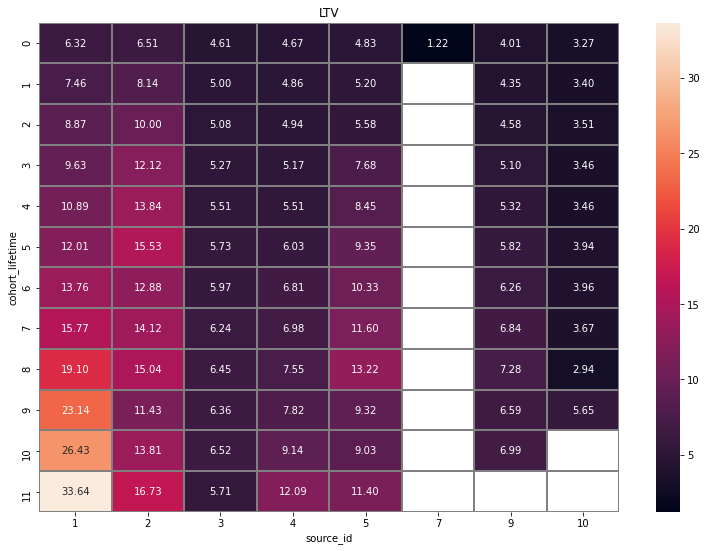

In [79]:
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 

Итак, видим, что первый источник самый прибыльный и рост его довольно стремительный. Второй также выделяется, причем до 5 месяца lifetime он более прибыльный, далее идет небольшой спад и рост уже не такой уверенный, как у 1-го источника. Также по прибыльности выделяются 4 и 5 источник. У 5-го спад на 8-ом месяце lifetime, может финансирование снизилось, нужно посмотреть на графиках по затратам. 

Самыми не прибыльными, относительно остальных источников, являются 3, 9, 10. 

Чтобы понять реальную картину необходимо понять их стоимость и окупаемость.

### 2.3 Маркетинг
<a id="marketing"></a>

**Сколько денег потратили? Всего / на каждый источник / по времени**

In [80]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [81]:
costs

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


Всего потратили около 330 тыс у.е

In [82]:
costs['costs'].sum()

329131.62

Посчитаем, сколько потратили денег в разрезе по каждому источнику рекламы

In [83]:
costs.groupby('source_id')[['costs']].sum().sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


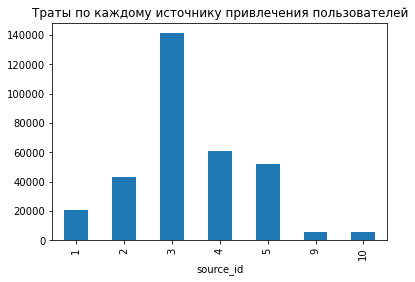

In [84]:
plt.title('Траты по каждому источнику привлечения пользователей')
costs.groupby('source_id')['costs'].sum().plot(kind='bar');

Самым растратным получился 3-ий источник. Также 2, 4, 5 получились довольно дорогостоющимися.  Посчитаем по месяцам расходы

In [85]:
cost_month = costs.groupby('month')[['costs']].sum().reset_index()
cost_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


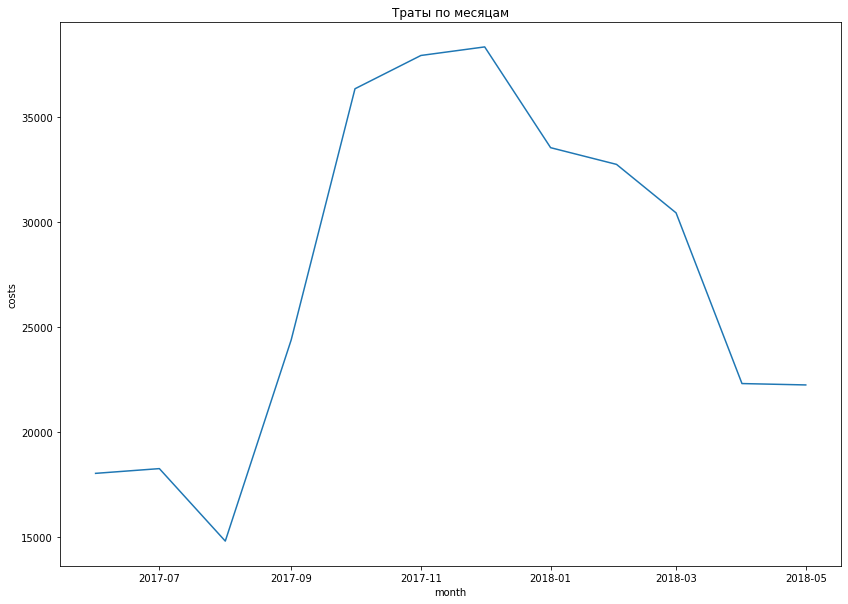

In [86]:
plt.figure(figsize=(14,10))
plt.title('Траты по месяцам')
sns.lineplot(data=cost_month, x = 'month', y = 'costs');

Видим, что с октября 2017 г траты сильно увеличиваются, после марта идут на спаl. Как и количество уникальных пользователей. Посмотрим на динамику затрат по источникам

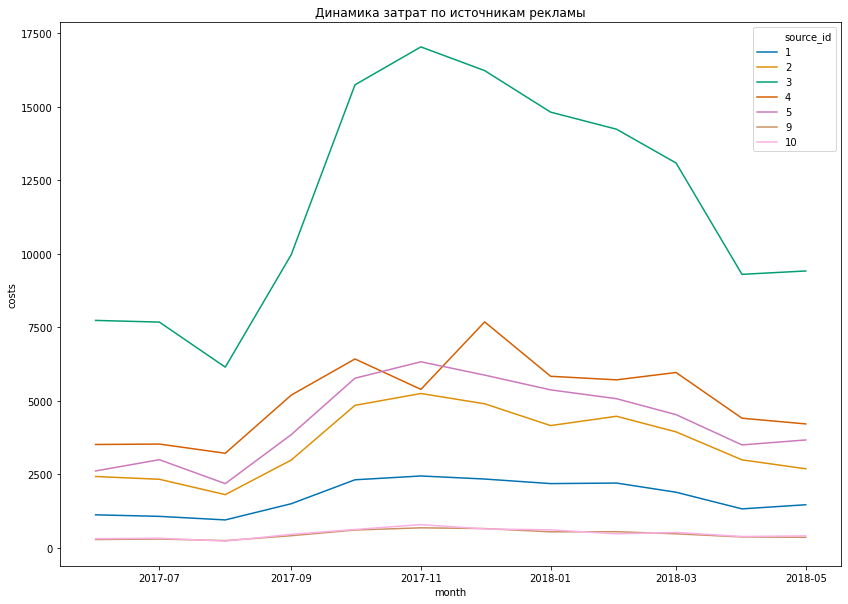

In [87]:
cost_month_source = costs.groupby(['month', 'source_id'])[['costs']].sum().reset_index()
plt.figure(figsize=(14,10))
plt.title('Динамика затрат по источникам рекламы')
palette = sns.color_palette("colorblind", cost_month_source['source_id'].nunique())
sns.lineplot(data=cost_month_source, x = 'month', y = 'costs', hue='source_id', palette=palette);

Итак, видим, что финансирование 9 и 10 источника находится на неизменно-низком уровне. Собственно и доходы с 1 пользователя выглядят примерно также, если вспомнить график LTV. 

В целом, все остальные источники примерно с сентября финансируются больше. И прибыли соответсвенно с октября становится больше. Затихают траты в апреле. Больше всего с сентября тратятся на 3-ий источник. Видим сильный всплеск в центре графика. При этом, если вспомнить по про график LTV, 3-ий источник - далеко не самый прибыльный. По LTV нас больше всего интересовали 1 и 2 источник, видим, что тратятся на них относительно немного. Вероятно, стоит обратить на них более пристальное внимание и увеличить расходы на рекламу.

**Сколько стоило привлечение одного покупателя из каждого источника?**

Посчитаем САС - Сумма денег, во сколько обходится новый клиент компании. Для начала нужно знать, сколько уникальных пользователей принес каждый источник

In [88]:
uniq_user_per_source = orders_log.groupby('source_id').agg({'uid': 'nunique'}).reset_index()

In [89]:
uniq_user_per_source

,source_id,uid
0,1,2896
1,2,3503
2,3,10467
3,4,10295
4,5,6931
5,7,1
6,9,1088
7,10,1327


Вытащим суммы по каждому источнику и соединим обе таблицы, посчитаем сумму на 1 пользователя

In [90]:
source_costs = costs.groupby('source_id')['costs'].sum()
source_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [91]:
source_costs_per_user = pd.merge(uniq_user_per_source, source_costs, on='source_id')
source_costs_per_user['cac'] = source_costs_per_user['costs'] / source_costs_per_user['uid']
source_costs_per_user.sort_values(by='cac', ascending=False)

,source_id,uid,costs,cac
2,3,10467,141321.63,13.501637
1,2,3503,42806.04,12.219823
4,5,6931,51757.10,7.467479
0,1,2896,20833.27,7.193809
3,4,10295,61073.60,5.932356
5,9,1088,5517.49,5.071222
6,10,1327,5822.49,4.387709


Видим, что дороже всего стоило привлечение пользователя в источниках 2,3. Также довольно дорогостоящими источниками являются 1 и 5. Немного дешевле - 4, 9, 10. А 6 и 7 источник вообще без затрат, права и пользователей оттуда пришло мало.

Помним, что самыми прибыльными являются 1 и 2 источник. 3-ий дорогой, но похоже толку от него мало, будем смотреть дальше на окупаемость.

**На сколько окупились расходы? (ROI)**


In [92]:
romi = cumsum_by_grouper.merge(source_costs_per_user, on='source_id')
romi

,cohort_lifetime,source_id,ltv,uid,costs,cac
0,0,1,6.319658,2896,20833.27,7.193809
1,1,1,7.464916,2896,20833.27,7.193809
2,2,1,8.874239,2896,20833.27,7.193809
3,3,1,9.633176,2896,20833.27,7.193809
4,4,1,10.887955,2896,20833.27,7.193809
...,...,...,...,...,...,...
76,5,10,3.943533,1327,5822.49,4.387709
77,6,10,3.960360,1327,5822.49,4.387709
78,7,10,3.674350,1327,5822.49,4.387709
79,8,10,2.941408,1327,5822.49,4.387709


In [93]:
romi['romi'] = romi['ltv'] / romi['cac']
romi

,cohort_lifetime,source_id,ltv,uid,costs,cac,romi
0,0,1,6.319658,2896,20833.27,7.193809,0.878486
1,1,1,7.464916,2896,20833.27,7.193809,1.037686
2,2,1,8.874239,2896,20833.27,7.193809,1.233594
3,3,1,9.633176,2896,20833.27,7.193809,1.339093
4,4,1,10.887955,2896,20833.27,7.193809,1.513517
...,...,...,...,...,...,...,...
76,5,10,3.943533,1327,5822.49,4.387709,0.898768
77,6,10,3.960360,1327,5822.49,4.387709,0.902603
78,7,10,3.674350,1327,5822.49,4.387709,0.837419
79,8,10,2.941408,1327,5822.49,4.387709,0.670374


In [94]:
romi_pivot = romi.pivot_table(index='cohort_lifetime', columns='source_id', values='romi', aggfunc='mean')
romi_pivot

source_id,1,2,3,4,5,9,10
cohort_lifetime,,,,,,,
0,0.878486,0.533011,0.341333,0.786705,0.647463,0.790423,0.745991
1,1.037686,0.666521,0.370125,0.818675,0.696766,0.857631,0.774361
2,1.233594,0.818092,0.376606,0.833559,0.747880,0.903565,0.799988
3,1.339093,0.991483,0.390107,0.872240,1.028575,1.006324,0.789487
4,1.513517,1.132257,0.408133,0.929151,1.131035,1.050033,0.789035
5,1.670046,1.270995,0.424745,1.016861,1.251486,1.146676,0.898768
6,1.913373,1.054214,0.441958,1.147391,1.382732,1.234533,0.902603
7,2.192655,1.155886,0.462256,1.175998,1.553853,1.348584,0.837419
8,2.655053,1.230764,0.478078,1.272225,1.770702,1.435950,0.670374


In [95]:
romi_pivot.mean(axis=1) 

cohort_lifetime
0     0.674773
1     0.745967
2     0.816184
3     0.916759
4     0.993309
5     1.097083
6     1.153829
7     1.246664
8     1.359021
9     1.396617
10    1.569444
11    2.006513
dtype: float64

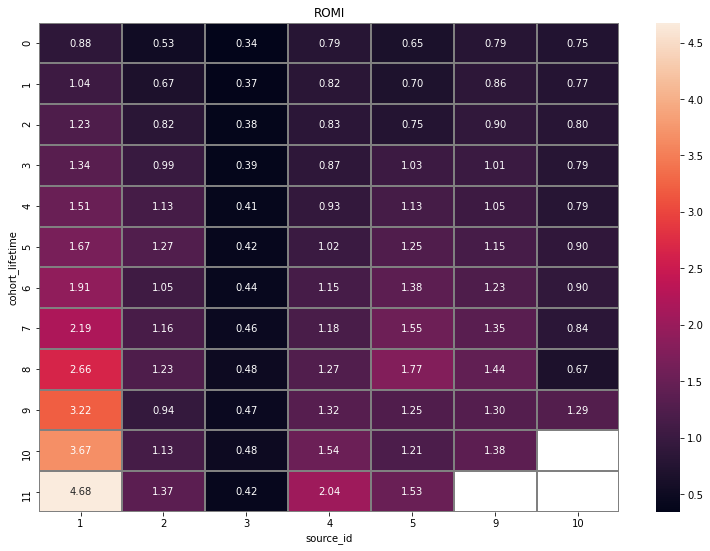

In [96]:
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(romi_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 

1-ый источник окупился уже на второй месяц и является самым окупаемым из всех. Далее по окупаемости следует 4-ый источник, но он окупается к 6-ому месяцу.
Следом - 2, 5, 9 - окупились на 4-ый/5-ый месяц и их окупаемость довольно высокая. 


3-ий по имеющимся данным не окупился. 10-ый окупился к последнему месяцу его lifetime.

### Шаг 3. Общий вывод
<a id="conclusion"></a> 

Итак, посчитав показатели LTV, CAC, ROMI можно сделать следующие выводы.

Самым окупаемым источников является 1-ый. Стоимость привлечения одного клиента не самая высокая. Он окупается практически сразу и его прибыль стремительно растет вверх. Думаю маркетологам стоит обратить на него самое пристальное внимание и финансировать максимально.


Следом по окупаемости выделяется 4-ый источник. Он обходится еще дешевле, прибыль с клиента довольно высокая, но окупается он только к 6-ому месяцу. То есть он довольно долгоиграющий, его также стоит финансировать, но иметь в виду, что доход можно получить только через полгода. 


Довольно сильные источники - 2, 5, 9. Хотя на первый взгляд 2 имеет наибольшую прибыль с человека, он один из самых дорогих, поэтому из этой группы получается наименее выгодным. И окупаются только к 4-5 месяцу.


Наименее выгодными получились 3 и 10. Причем 3-ий источник наиболее дорогой и еще не окупился. 

Итак, советую маркетологам обратить внимание на следующие источники (расположены от самого рекомендованного источника к менее):
- 1
- 4
- 5
- 9
- 2
- 10
- 3